Загрузим нужные библиотеки

In [34]:
! python -m spacy download ru_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 15.3/15.3 MB 7.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [35]:
import pandas as pd
import unicodedata
import re
import spacy
import json
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Подготовка данных

Загрузим данные

In [36]:
data = pd.read_csv('csv\\full_df.csv', sep=';')
data.head(3)
data = data.drop(columns='Unnamed: 0', axis=1)

Отфильтруем тексты по количеству символов. Оставим только 100+.

In [37]:
data['text_len'] = data.loc[:, 'text'].apply(lambda x: len(x))
data_filtered_by_text_len = data.query('text_len > 100')
print(f'Количество постов с 100+ символами: {data_filtered_by_text_len.shape[0]}')
data_filtered_by_text_len.head(3)

Количество постов с 100+ символами: 8556


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Оставим только тексты содержащие кириллицу

In [38]:
data_cyrillic = data_filtered_by_text_len[data_filtered_by_text_len['text'].apply(lambda x: re.match(r'[А-Яа-я]+', x) is not None)]

print(f'Текстов на кириллице: {data_cyrillic.shape[0]}')
data_cyrillic.head(3)

Текстов на кириллице: 1960


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Удалим дубликаты текстов

In [39]:
data_dd = data_cyrillic.drop_duplicates('text')
print(f'Осталось {data_dd.shape[0]} строк')
data_dd.head(3)

Осталось 1862 строк


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
6,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,С трепетом готов представить свой продукт. Реф...,8.0,0.0,0.0,841


In [40]:
# Список слов для фильтрации
words = ['наставничество', 'наставник', 'ментор', 'коуч', 'mentorship', 'mentor', 'coaching', 'buddy']

# Фильтрация строк, содержащих хотя бы одно слово из списка
filtered_df = data_dd[data_dd['text'].str.contains('|'.join(words), case=False, regex=True)]

# Подготовка к моделированию

In [41]:
texts = data_dd["text"].tolist()
texts[0]

'Всем привет!Выпустил свою первую статью на хабр!https://lnkd.in/dt9N6D7BСтатья про историю и технологии разработки игры https://guess-word.com и как мы создали игру с элементами машинного обучения и вышли в ноль за 2 месяцаПри\xa0внимательном прочтении вы даже сможете запустить первую версию игры!'

Проведем лемматизацию

In [42]:
if os.path.exists('lemmas.json'):
    with open("lemmas.json") as f:
        data_lemmatized = json.load(f)['lemmas']
else:
    model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])
    data_lemmatized = []
    for doc in model.pipe(texts, disable=["tagger", "parser"]):
        data_lemmatized.append([token.lemma_ for token in doc])

    with open("lemmas.json", "w") as fid:
        json.dump({"lemmas": data_lemmatized}, fid)

print(data_lemmatized[0])

['#', 'hiring', '\xa0', '#', 'seniords', '\xa0', 'всем', 'привет', '!', 'я', 'находиться', 'в', 'поиск', 'senoir', 'ds', 'в', 'свой', 'команда', '.', 'подробный', 'описание', 'вакансия', 'низкий', '.', 'быть', 'благодарный', 'за', 'репост', '!', '\xa0', 'компания', ':', 'сбербанкподразделение', ':', 'блок', 'финансы', ',', 'управление', 'моделирование', 'и', 'исследование', 'данныхпозиция', ':', 'senior', 'data', 'scientistнаш', 'команда', 'заниматься', 'r&d', 'прогнозирование', 'численный', 'метрика', 'cltv', '(', 'client', 'life', '-', 'time', 'value', ')', 'по', 'клиент', '–', 'физический', 'лицо', 'сбербанк', '.', 'мы', 'искать', 'data', 'scientist’a', 'с', 'опыт', 'работа', 'с', 'модель', 'последовательность', 'событие', '(', 'transformer', ',', 'lstm', ',', 'embeddings', ')', 'и', 'c', 'классический', 'машинный', 'обучение', 'на', 'табличный', 'данных', '(', 'gradient', 'boosting', ',', 'rf', ')', ',', 'который', 'смочь', 'имплементировать', 'sota', 'ml', '-', 'решение', 'в', 'мо

Очистим тексты от ненужных символов

In [43]:
word_pattern = re.compile("^[а-я]*$")

def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

data_words = list(map(remove_symbols, data_lemmatized))
print(data_words[0])

['всем', 'привет', 'я', 'находиться', 'в', 'поиск', 'в', 'свой', 'команда', 'подробный', 'описание', 'вакансия', 'низкий', 'быть', 'благодарный', 'за', 'репост', 'компания', 'сбербанкподразделение', 'блок', 'финансы', 'управление', 'моделирование', 'и', 'исследование', 'данныхпозиция', 'команда', 'заниматься', 'прогнозирование', 'численный', 'метрика', 'по', 'клиент', 'физический', 'лицо', 'сбербанк', 'мы', 'искать', 'с', 'опыт', 'работа', 'с', 'модель', 'последовательность', 'событие', 'и', 'классический', 'машинный', 'обучение', 'на', 'табличный', 'данных', 'который', 'смочь', 'имплементировать', 'решение', 'в', 'модель', 'прогнозирование', 'основной', 'зона', 'ответственность', 'в', 'рамка', 'направление', 'разработка', 'модель', 'для', 'база', 'млн', 'розничный', 'клиент', 'сбербанк', 'создание', 'и', 'тестирование', 'представление', 'клиент', 'для', 'использование', 'в', 'модель', 'работа', 'с', 'огромный', 'массив', 'данных', 'разработка', 'подход', 'по', 'чувствительность', 'про

Загрузим русские стоп-слова

In [44]:
stop_words = stopwords.words('russian')
stop_words += ['это', 'свой', 'очень', 'мочь', 'ваш', 'наш']

Определим функцию для удаления стоп-слов

In [45]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

Применим функцию для удаления стоп-слов

In [46]:
data_words_nostops = remove_stopwords(data_words)

In [47]:
id2word = corpora.Dictionary(data_words_nostops)

texts = data_words_nostops

corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('архитектура', 1),
  ('база', 1),
  ('банк', 2),
  ('банковский', 1),
  ('белов', 1),
  ('бизнес', 2),
  ('благодарный', 1),
  ('блок', 1),
  ('вакансия', 1),
  ('взаимодействие', 1),
  ('внешний', 1),
  ('возможность', 1),
  ('всем', 1),
  ('входной', 1),
  ('вшэ', 1),
  ('вывод', 1),
  ('гибридный', 1),
  ('год', 1),
  ('график', 1),
  ('графовых', 1),
  ('данных', 5),
  ('данныхпозиция', 1),
  ('действие', 1),
  ('день', 1),
  ('дом', 1),
  ('дружный', 1),
  ('екатерина', 1),
  ('желание', 1),
  ('задач', 1),
  ('задача', 2),
  ('заинтересоваться', 1),
  ('заниматься', 1),
  ('знание', 2),
  ('зона', 1),
  ('изменение', 1),
  ('имплементировать', 1),
  ('искать', 1),
  ('использование', 1),
  ('исследование', 1),
  ('исследователь', 1),
  ('кандидат', 1),
  ('классический', 2),
  ('клиент', 4),
  ('ключ', 1),
  ('команда', 5),
  ('компания', 1),
  ('компенсация', 1),
  ('комфортабельный', 1),
  ('конкурентный', 1),
  ('корпоративный', 1),
  ('который', 1),
  ('кутузовский', 1),
 

# Протестируем моделирование с 20 темами

In [49]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
    )

In [50]:
lda_model.print_topics()

[(0,
  '0.029*"пост" + 0.016*"решение" + 0.015*"считать" + 0.015*"взять" + 0.014*"красивый" + 0.010*"точно" + 0.010*"менти" + 0.009*"любой" + 0.009*"пытаться" + 0.008*"которого"'),
 (1,
  '0.043*"момент" + 0.028*"спасибо" + 0.026*"небольшой" + 0.024*"россия" + 0.021*"общий" + 0.018*"успеть" + 0.017*"никто" + 0.015*"интерес" + 0.014*"ответить" + 0.014*"данный"'),
 (2,
  '0.003*"проектноеобучение" + 0.003*"директ" + 0.000*"чувствовать" + 0.000*"персональный" + 0.000*"созреть" + 0.000*"увлечь" + 0.000*"развить" + 0.000*"обучениеснуля" + 0.000*"управлениепроектами" + 0.000*"нуль"'),
 (3,
  '0.040*"запрос" + 0.032*"аналитик" + 0.029*"встреча" + 0.028*"поделиться" + 0.024*"продуктовый" + 0.017*"менторство" + 0.015*"давать" + 0.015*"завтра" + 0.014*"хотеть" + 0.014*"кейс"'),
 (4,
  '0.033*"другие" + 0.026*"начало" + 0.022*"способ" + 0.021*"компетенция" + 0.019*"портфолио" + 0.015*"позволить" + 0.013*"источник" + 0.010*"которое" + 0.009*"заказ" + 0.007*"полтора"'),
 (5,
  '0.003*"арсен" + 0.00

Вычислим сложность и согласованность модели

In [51]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -11.857263164618981
Coherence Score:  0.4622738315766578


Отобразим результаты моделирования

In [52]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.326227  0.022388       1        1  45.721183
7      0.230680  0.213834       2        1  14.084256
8      0.241009 -0.188505       3        1  11.076454
0      0.043037  0.062578       4        1   6.259408
9      0.095744 -0.185385       5        1   5.981948
3      0.027825  0.093707       6        1   3.456310
1     -0.061394  0.006114       7        1   2.454664
6     -0.043723 -0.007050       8        1   2.429790
4     -0.071006 -0.009811       9        1   1.579700
13    -0.077935 -0.005517      10        1   1.492286
12    -0.086223  0.004903      11        1   1.330605
15    -0.080200 -0.003126      12        1   0.991562
11    -0.078890 -0.003309      13        1   0.770038
16    -0.075538 -0.002964      14        1   0.682633
17    -0.072422  0.000903      15        1   0.501021
19    -0.074855 -0.002224      16        1   0.485179
18    -0.068654  0.002263      17        1   0.392229
14    -0.060935  0.000202      18        1   0.202326
5     -0.056646  0.000497      19        1   0.063018
2     -0.056103  0.000502      20        1   0.045392, topic_info=             Term        Freq       Total Category  logprob  loglift
44        команда  120.000000  120.000000  Default  30.0000  30.0000
101        работа  210.000000  210.000000  Default  29.0000  29.0000
78           опыт  126.000000  126.000000  Default  28.0000  28.0000
446        хотеть   85.000000   85.000000  Default  27.0000  27.0000
1470       сессия   23.000000   23.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
140      говорить    0.001556   16.371024  Topic20  -8.2907  -1.5633
31     заниматься    0.001556   27.837539  Topic20  -8.2907  -2.0942
172       человек    0.001556  102.107124  Topic20  -8.2907  -3.3938
588   компетенция    0.001556    5.335586  Topic20  -8.2907  -0.4422
413          пост    0.001556   42.536057  Topic20  -8.2907  -2.5182

[972 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
884       7  0.898722      абсолютно
1761      3  0.885474      агентство
1480     12  0.964121           айти
1108      2  0.879543       академия
1108      4  0.097727       академия
...     ...       ...            ...
1458      2  0.985763         эмоция
1825      4  0.750775        эмпатия
1673      2  0.843883  эффективность
1673      4  0.153433  эффективность
1992     10  0.507723       языковой

[832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 8, 9, 1, 10, 4, 2, 7, 5, 14, 13, 16, 12, 17, 18, 20, 19, 15, 6, 3])

# Подбор количества тем

Подберем количество тем основываясь на согласованности модели

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=765,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_nostops, start=1, limit=20, step=1)

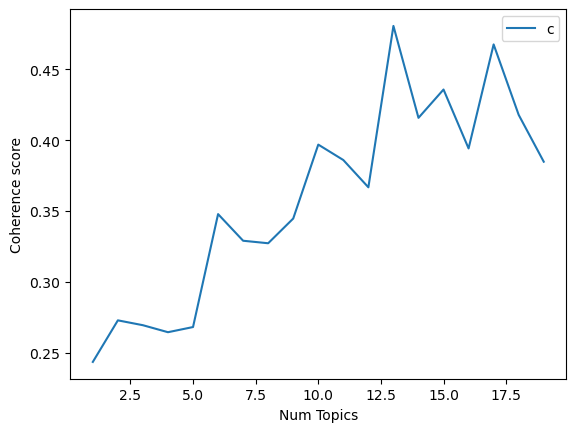

In [57]:
limit=20
start=1
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Наилучший результат показала модель с 3 темами

In [58]:
def model_scorer(data):
    id2word = corpora.Dictionary(data)

    texts = data

    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=13, 
        random_state=765,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

    print('Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

    return lda_model, corpus, id2word

best_model, best_corpus, best_id2word = model_scorer(data_words_nostops)

Perplexity:  -9.419887730826815
Coherence Score:  0.4806771828036434


# Использование биграмм и триграмм

Проверим, повлияет ли использование биграмм и триграмм на согласованность модели

In [59]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [60]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

In [61]:
model_scorer(data_words_bigrams)
print('Complete')

Perplexity:  -9.394437748184869
Coherence Score:  0.3651174519376338
Complete


In [62]:
model_scorer(data_words_trigrams)
print('Complete')

Perplexity:  -9.394437748184869
Coherence Score:  0.3651174519376338
Complete


Использование биграмм и триграмм только ухудшили согласованнось

# Анализ наилучшей модели

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, best_corpus, best_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.296180 -0.123892       1        1  54.288832
11     0.209640  0.247571       2        1  16.033909
7      0.095168 -0.128888       3        1   9.741908
5      0.004920 -0.029458       4        1   6.562172
12    -0.023782 -0.004890       5        1   3.240964
6     -0.078750  0.005295       6        1   2.297007
10    -0.091920  0.005067       7        1   2.209193
9     -0.091450  0.006170       8        1   1.643529
2     -0.061401  0.009149       9        1   1.161500
0     -0.067408  0.003916      10        1   1.110781
1     -0.072330  0.003721      11        1   0.996852
3     -0.059827  0.002033      12        1   0.416824
8     -0.059040  0.004206      13        1   0.296529, topic_info=                   Term       Freq      Total Category  logprob  loglift
103          разработка  42.000000  42.000000  Default  30.0000  30.0000
29               задача  35.000000  35.000000  Default  29.0000  29.0000
5                бизнес  70.000000  70.000000  Default  28.0000  28.0000
74             обучение  27.000000  27.000000  Default  27.0000  27.0000
413                пост  38.000000  38.000000  Default  26.0000  26.0000
...                 ...        ...        ...      ...      ...      ...
584         приобретать   0.081723   0.978035  Topic13  -6.2065   3.3386
3551            алексей   0.021854   0.577653  Topic13  -7.5255   2.5462
3569           институт   0.010031   0.564291  Topic13  -8.3042   1.7909
3570  нейрографического   0.010031   0.564291  Topic13  -8.3042   1.7909
1604          начальник   0.012084   2.619722  Topic13  -8.1180   0.4418

[607 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2138      7  0.641338     адаптивный
2139      7  0.652591   адаптируются
1534      5  0.985012        адхоков
1480      3  0.937174           айти
1108      1  0.968578       академия
...     ...       ...            ...
586       9  0.677633      этопросто
353       2  0.556180           эфир
1673      2  0.929656  эффективность
720       1  0.981388           язык
2297      6  0.649218           якщо

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 8, 6, 13, 7, 11, 10, 3, 1, 2, 4, 9])

In [64]:
topic_probs = best_model.get_document_topics(best_corpus)
max_prob_topics = list(map(lambda doc_probs: max(doc_probs, key=lambda x: x[1])[0], topic_probs))

In [65]:
df = pd.DataFrame([list(data_dd["text"]), max_prob_topics]).transpose()
df.columns = ['text', 'topic_label']
df.head(3)

,text,topic_label
0,Всем привет!Выпустил свою первую статью на хаб...,4
1,"Если вам интересно позалипать в слова, я запус...",11
2,С трепетом готов представить свой продукт. Реф...,4


In [66]:
df.loc[df['topic_label'] == 1].head()

,text,topic_label
54,Ребята из #SberIDP опубликовали отличную стать...,1
83,В команду Авито за 2 дня? Реально!Зарегистриру...,1


# Вывод

С имеющимися данными наилучшую согласованность имеет модель с разделением на 13 тем. Выведем топ слов по каждой теме.

In [99]:
N_TOPICS = 13
for i in range(N_TOPICS):
    print("Тема",i+1, ":")
    print(best_model.show_topic(i))

Тема 1 :
[('взять', 0.030086955), ('жизненный', 0.016843785), ('возможно', 0.012119896), ('польза', 0.010954338), ('возникать', 0.010823718), ('пост', 0.010628193), ('опрос', 0.009067703), ('пусть', 0.0082249995), ('ощущение', 0.007640954), ('создать', 0.007602942)]
Тема 2 :
[('приложение', 0.02078733), ('разработка', 0.01586293), ('малый', 0.015698161), ('коучем', 0.011009692), ('тимлида', 0.010999971), ('радовать', 0.010991257), ('мобильный', 0.009138011), ('фонд', 0.009026708), ('территория', 0.009026708), ('женский', 0.0086907875)]
Тема 3 :
[('интерфейс', 0.02580471), ('пользовательский', 0.02033558), ('погнать', 0.016644336), ('обучение', 0.0144676985), ('профессия', 0.012577747), ('персональный', 0.011729988), ('управлениепроектами', 0.010228804), ('обучениеснуля', 0.0088120345), ('тебе', 0.007757738), ('наставник', 0.007756928)]
Тема 4 :
[('процент', 0.007299462), ('рассказывать', 0.0051552705), ('рассказчик', 0.0037636594), ('фильм', 0.0037636573), ('информационный', 0.00376364